In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences

# print(os.listdir("../input"))

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', -1)

# Any results you write to the current directory are saved as output.

In [11]:
df = pd.read_csv("/kaggle/input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

In [12]:
df['source'].value_counts()

source
tides        50000
ted          39881
indic2012    37726
Name: count, dtype: int64

In [13]:
df

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
...,...,...,...
127602,indic2012,Examples of art deco construction can be found...,आर्ट डेको शैली के निर्माण मैरीन ड्राइव और ओवल ...
127603,ted,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।
127604,tides,"As for the other derivatives of sulphur , the ...","जहां तक गंधक के अन्य उत्पादों का प्रश्न है , द..."
127605,tides,its complicated functioning is defined thus in...,Zरचना-प्रकिया को उसने एक पहेली में यों बांधा है .


In [14]:
df.drop('source', axis=1, inplace=True)

In [15]:
df.isnull().sum()

english_sentence    2
hindi_sentence      0
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
def data_cleaning(text):

    # Convert to lower
    text = text.lower()

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d", '', text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    return text

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127605 entries, 0 to 127606
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   english_sentence  127605 non-null  object
 1   hindi_sentence    127605 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [19]:
df['cleaned_english_sentence'] = df['english_sentence'].apply(data_cleaning)
df['cleaned_hindi_sentence'] = df['hindi_sentence'].apply(data_cleaning)

In [20]:
# Add start and end tokens to target sequences
df['cleaned_hindi_sentence'] = df['cleaned_hindi_sentence'].apply(lambda x : 'start '+ x + ' end')

In [21]:
df

,english_sentence,hindi_sentence,cleaned_english_sentence,cleaned_hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",politicians do not have permission to do what ...,start राजनीतिज्ञों के पास जो कार्य करना चाहिए ...
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,id like to tell you about one such child,start मई आपको ऐसे ही एक बच्चे के बारे में बतान...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,this percentage is even greater than the perce...,start यह प्रतिशत भारत में हिन्दुओं प्रतिशत से ...
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,what we really mean is that theyre bad at not ...,start हम ये नहीं कहना चाहते कि वो ध्यान नहीं द...
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,the ending portion of these vedas is called up...,start इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता ...
...,...,...,...,...
127602,Examples of art deco construction can be found...,आर्ट डेको शैली के निर्माण मैरीन ड्राइव और ओवल ...,examples of art deco construction can be found...,start आर्ट डेको शैली के निर्माण मैरीन ड्राइव औ...
127603,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।,and put it in our cheeks,start और अपने गालों में डाल लेते हैं। end
127604,"As for the other derivatives of sulphur , the ...","जहां तक गंधक के अन्य उत्पादों का प्रश्न है , द...",as for the other derivatives of sulphur the co...,start जहां तक गंधक के अन्य उत्पादों का प्रश्न ...
127605,its complicated functioning is defined thus in...,Zरचना-प्रकिया को उसने एक पहेली में यों बांधा है .,its complicated functioning is defined thus in...,start zरचनाप्रकिया को उसने एक पहेली में यों बा...


In [22]:
# Shuffle the dataframe
df = df.sample(n=10, random_state=42).reset_index(drop=True)

In [23]:
df.head()

,english_sentence,hindi_sentence,cleaned_english_sentence,cleaned_hindi_sentence
0,He declares the result and reports it to the E...,वही परिणाम की घोषणा करता है और निर्वाचन आयोग क...,he declares the result and reports it to the e...,start वही परिणाम की घोषणा करता है और निर्वाचन ...
1,was a little uncomfortable for them.,थोडा कठिन था।,was a little uncomfortable for them,start थोडा कठिन था। end
2,"A multi-purpose auditorium , a branch of the S...","बहुउद्देशीय सभागार , भारतीय स्टेट बैंक की शाखा...",a multipurpose auditorium a branch of the stat...,start बहुउद्देशीय सभागार भारतीय स्टेट बैंक की ...
3,No fees is to be paid for filing the appeal to...,अधिकरण में अपील करने के लिए कोई फीस नहीं देनी ...,no fees is to be paid for filing the appeal to...,start अधिकरण में अपील करने के लिए कोई फीस नहीं...
4,headind kaun banega crorepati,शीर्षक कौन बनेगा करोड़पति (Kaun Banega Crorepa...,headind kaun banega crorepati,start शीर्षक कौन बनेगा करोड़पति kaun banega cr...


In [24]:
df['hindi_sentence'][0], df['cleaned_hindi_sentence'][0]

('वही परिणाम की घोषणा करता है और निर्वाचन आयोग को और संबद्ध सदन के महासचिव को उसकी सूचना देता है .',
 'start वही परिणाम की घोषणा करता है और निर्वाचन आयोग को और संबद्ध सदन के महासचिव को उसकी सूचना देता है  end')

In [25]:
#Tokenize the texts and convert to sequences
en_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='')
en_tokenizer.fit_on_texts(df['cleaned_english_sentence'])
# en_sequences = en_tokenizer.texts_to_sequences(df['cleaned_english_sentence'])

hi_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='')
hi_tokenizer.fit_on_texts(df['cleaned_hindi_sentence'])
# hi_sequences = hi_tokenizer.texts_to_sequences(df['cleaned_hindi_sentence'])

english_vocab_size = len(en_tokenizer.word_index) + 1
hindi_vocab_size = len(hi_tokenizer.word_index) + 1
print("English Vocab Size: ", english_vocab_size)
print("Hindi Vocab Size: ", hindi_vocab_size)

English Vocab Size:  88
Hindi Vocab Size:  107


In [26]:
en_max_length = df['cleaned_english_sentence'].apply(lambda x:len(str(x).split())).max()
hi_max_length = df['cleaned_hindi_sentence'].apply(lambda x:len(str(x).split())).max()

en_max_length, hi_max_length

(32, 31)

In [27]:
X = df['cleaned_english_sentence']
y = df['cleaned_hindi_sentence']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

In [92]:
len(X_train), len(y_train)

(8, 8)

In [115]:
X_train[0:500]

5    no other national leader except nehru shared t...
0    he declares the result and reports it to the e...
7                                      oraiya district
2    a multipurpose auditorium a branch of the stat...
9              just as the poets and writers described
4                        headind kaun banega crorepati
3    no fees is to be paid for filing the appeal to...
6    bachchan continued togive their support to the...
Name: cleaned_english_sentence, dtype: object

In [101]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            # One-hot encoding input sequences
            encoder_input_data = []
            decoder_input_data = []
            decoder_target_data = []
        
            temp_decoder_target_data = np.zeros((batch_size, hi_max_length, len(hi_tokenizer.word_index) + 1), dtype='float32')
            
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                print("inside")
                en_sequences = en_tokenizer.texts_to_sequences(input_text)
                temp_encoder_input = pad_sequences(en_sequences, maxlen=en_max_length, padding='post')

                hi_sequences = hi_tokenizer.texts_to_sequences(target_text)
                temp_decoder_input = pad_sequences(hi_sequences, maxlen=hi_max_length, padding='post')

                for t, token in enumerate(target_text.split()):
                    if t > 0:
                        index = hi_tokenizer.word_index[token]
                        temp_decoder_target_data[i, t-1, index] = 1.0

#                 print("Size taken by the array:", temp_decoder_target_data.nbytes, "bytes")
                
                print("append")
                encoder_input_data.append(temp_encoder_input)
                decoder_input_data.append(temp_decoder_input)
                decoder_target_data.append(temp_decoder_target_data)
                print(len(encoder_input_data), len(decoder_input_data))

            encoder_input_data = np.vstack(encoder_input_data)
            decoder_input_data = np.vstack(decoder_input_data)
            decoder_target_data = np.vstack(decoder_target_data)
            print(encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape)
            print(len(encoder_input_data), len(decoder_input_data))

            yield (encoder_input_data, decoder_input_data), (decoder_target_data)
        
        
#         for t, word in enumerate(input_text.split()):
#             encoder_input_data[i, t] = input_token_index[word] # encoder input seq
#         for t, word in enumerate(target_text.split()):
#             if t<len(target_text.split())-1:
#                 decoder_input_data[i, t] = target_token_index[word] # decoder input seq
#             if t>0:
#                 # decoder target sequence (one hot encoded)
#                 # does not include the START_ token
#                 # Offset by one timestep
#                 decoder_target_data[i, t - 1, target_token_index[word]] = 1.
#         yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [124]:
a = [[1, 2, 3] , [4,5,6]]
c = np.vstack(a)
c

array([[1, 2, 3],
       [4, 5, 6]])

In [117]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.concatenate((a, b), axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [30]:
# #Tokenize the texts and convert to sequences
# en_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='')
# en_tokenizer.fit_on_texts(df['cleaned_english_sentence'])
# en_sequences = en_tokenizer.texts_to_sequences(df['cleaned_english_sentence'])

# hi_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='')
# hi_tokenizer.fit_on_texts(df['cleaned_hindi_sentence'])
# hi_sequences = hi_tokenizer.texts_to_sequences(df['cleaned_hindi_sentence'])

# english_vocab_size = len(en_tokenizer.word_index) + 1
# hindi_vocab_size = len(hi_tokenizer.word_index) + 1
# print("English Vocab Size: ", english_vocab_size)
# print("Hindi Vocab Size: ", hindi_vocab_size)

In [31]:
# en_max_length = df['cleaned_english_sentence'].apply(lambda x:len(str(x).split())).max()
# hi_max_length = df['cleaned_hindi_sentence'].apply(lambda x:len(str(x).split())).max()

# en_max_length, hi_max_length

In [32]:
# encoder_input = pad_sequences(en_sequences, maxlen=en_max_length, padding='post')
# decoder_input = pad_sequences(hi_sequences, maxlen=hi_max_length, padding='post')

In [33]:
# print("Size taken by the array:", encoder_input.nbytes, "bytes")

# size_in_bytes = encoder_input.nbytes
# size_in_kilobytes = size_in_bytes / 1024
# size_in_megabytes = size_in_kilobytes / 1024
# size_in_gigabytes = size_in_megabytes / 1024

# print("Size taken by the array:", size_in_bytes, "bytes")
# print("Size taken by the array:", size_in_kilobytes, "KB")
# print("Size taken by the array:", size_in_megabytes, "MB")
# print("Size taken by the array:", size_in_gigabytes, "GB")

# Size taken by the array: 203147160 bytes
# Size taken by the array: 203147160 bytes
# Size taken by the array: 198385.8984375 KB
# Size taken by the array: 193.7362289428711 MB
# Size taken by the array: 0.18919553607702255 GB

In [34]:
# hi_tokenizer.word_index
len(hi_tokenizer.word_index)

106

In [35]:
# # One-hot encoding input sequences
# decoder_target_data = np.zeros((len(df['cleaned_hindi_sentence']), hi_max_length, len(hi_tokenizer.word_index) + 1), dtype='float32')
# for i, text in enumerate(df['cleaned_hindi_sentence']):
#     for t, token in enumerate(text.split()):
#         if t > 0:
#             index = hi_tokenizer.word_index[token]
#             decoder_target_data[i, t-1, index] = 1.0
    

In [36]:
# print("Size taken by the array:", decoder_target_data.nbytes, "bytes")

# size_in_bytes = decoder_target_data.nbytes
# size_in_kilobytes = size_in_bytes / 1024
# size_in_megabytes = size_in_kilobytes / 1024
# size_in_gigabytes = size_in_megabytes / 1024

# print("Size taken by the array:", size_in_bytes, "bytes")
# print("Size taken by the array:", size_in_kilobytes, "KB")
# print("Size taken by the array:", size_in_megabytes, "MB")
# print("Size taken by the array:", size_in_gigabytes, "GB")

# Size taken by the array: 17532519174420 bytes
# Size taken by the array: 17532519174420 bytes
# Size taken by the array: 17121600756.269531 KB
# Size taken by the array: 16720313.238544464 MB
# Size taken by the array: 16328.430897016078 GB

In [69]:
X_train

5    no other national leader except nehru shared t...
0    he declares the result and reports it to the e...
7                                      oraiya district
2    a multipurpose auditorium a branch of the stat...
9              just as the poets and writers described
4                        headind kaun banega crorepati
3    no fees is to be paid for filing the appeal to...
6    bachchan continued togive their support to the...
Name: cleaned_english_sentence, dtype: object

In [102]:
latent_dim = 50
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(english_vocab_size, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [103]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(hindi_vocab_size, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(hindi_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [104]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, None, 50)  │      4,400 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_16        │ (None, None)      │          0 │ input_layer_16[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, None, 50)  │      5,350 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ [(None, 50),      │     20,200 │ embedding_16[0][… │
│                     │ (None, 50),       │            │ not_equal_16[0][… │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, None,     │     20,200 │ embedding_17[0][… │
│                     │ 50), (None, 50),  │            │ lstm_16[0][1],    │
│                     │ (None, 50)]       │            │ lstm_16[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, None, 107) │      5,457 │ lstm_17[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,607 (217.21 KB)

 Trainable params: 55,607 (217.21 KB)

 Non-trainable params: 0 (0.00 B)

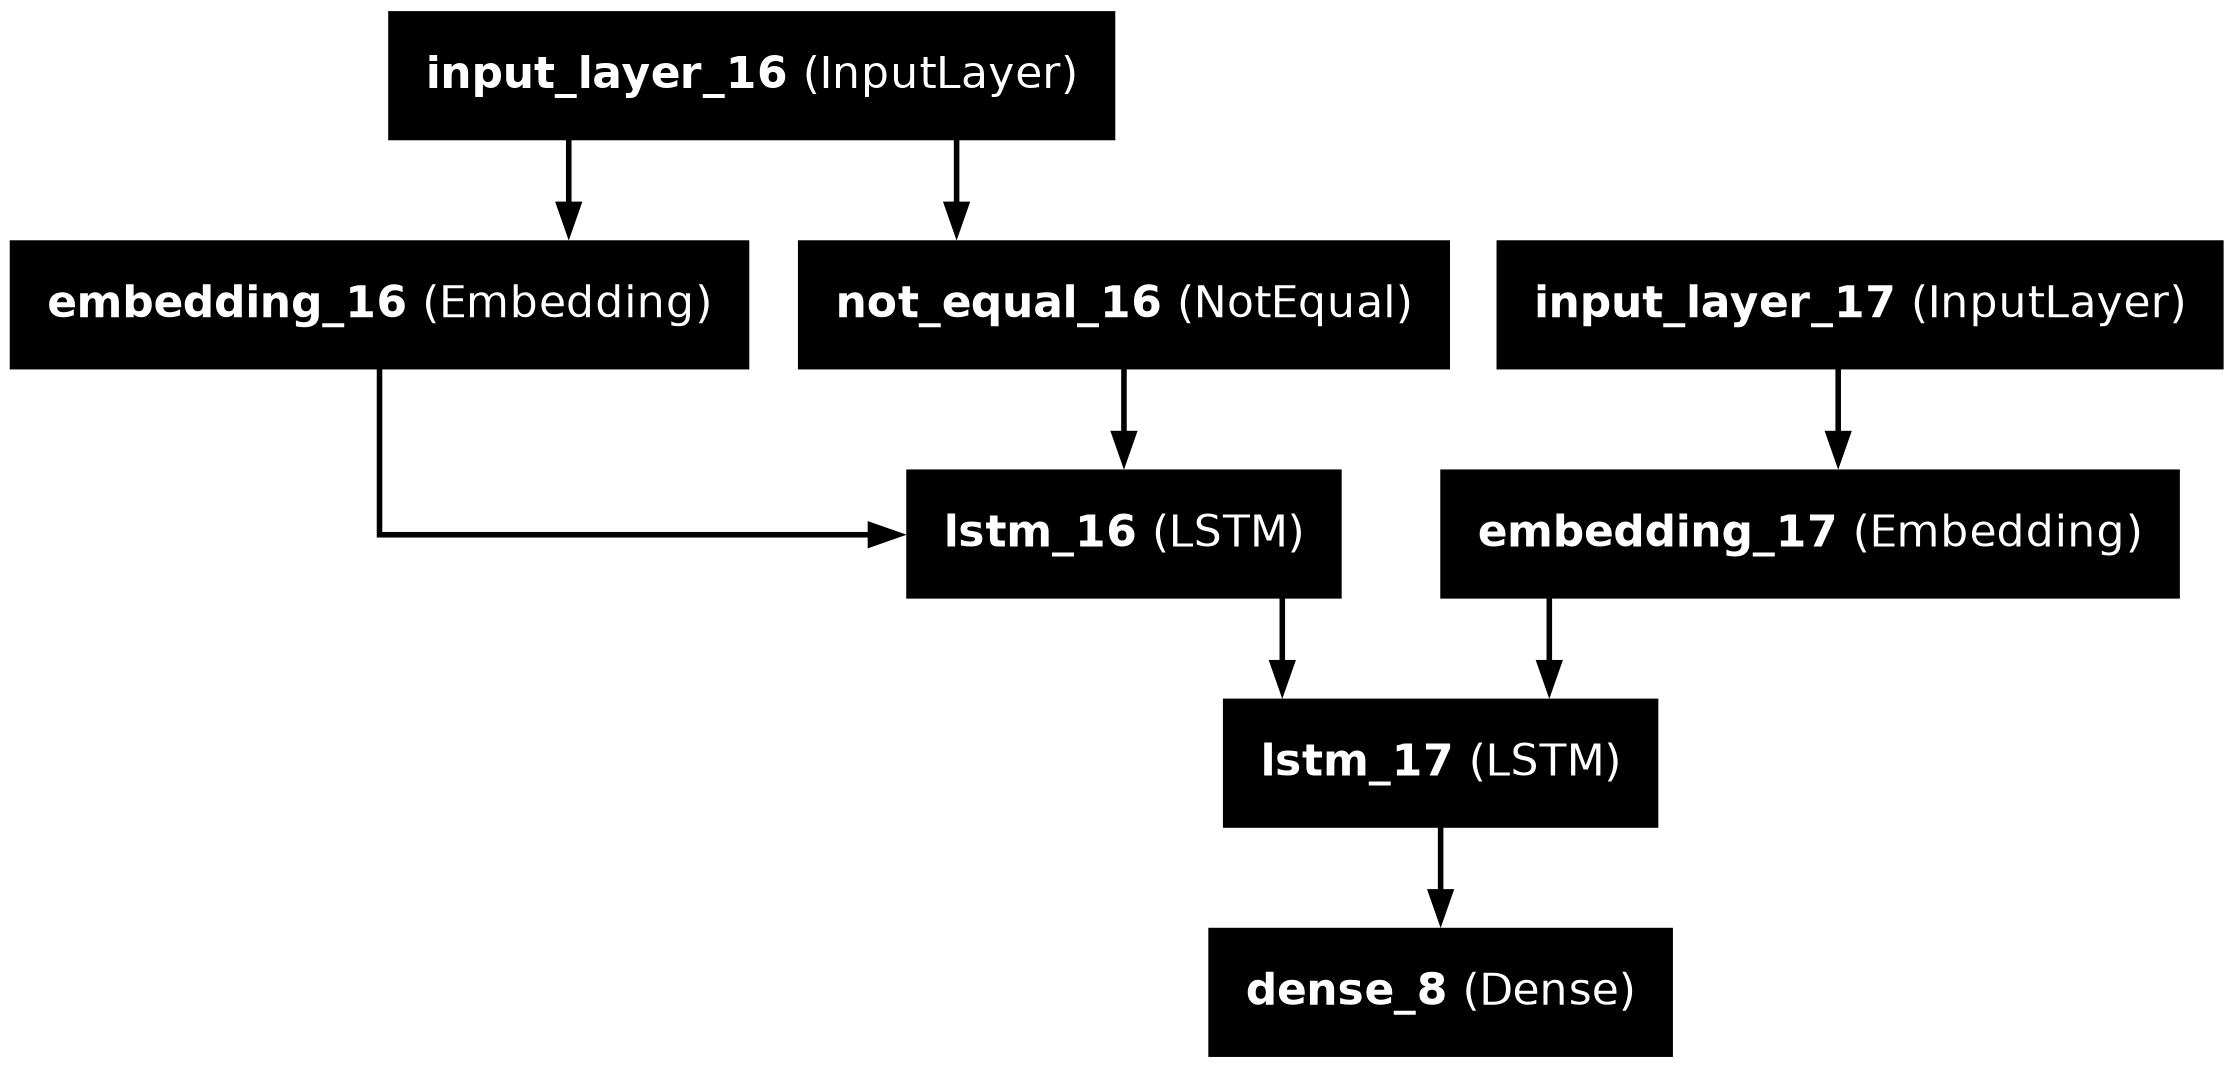

In [105]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_layer_names=True)

In [106]:
# [encoder_input[0], decoder_input[0]]

In [51]:
# def generate_batch(X = X_train, y = y_train, batch_size = 128):
#     ''' Generate a batch of data '''
#     while True:
#         for j in range(0, len(X), batch_size):
#             encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
#             decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
#             decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
#             for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
#                 for t, word in enumerate(input_text.split()):
#                     encoder_input_data[i, t] = input_token_index[word] # encoder input seq
#                 for t, word in enumerate(target_text.split()):
#                     if t<len(target_text.split())-1:
#                         decoder_input_data[i, t] = target_token_index[word] # decoder input seq
#                     if t>0:
#                         # decoder target sequence (one hot encoded)
#                         # does not include the START_ token
#                         # Offset by one timestep
#                         decoder_target_data[i, t - 1, target_token_index[word]] = 1.
#             yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [42]:
# model.fit(
#     [encoder_input, decoder_input],
#     decoder_target_data,
#     epochs=100,
#     validation_split=0.2
# )

In [43]:
model

<Functional name=functional_1, built=True>

In [107]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

In [108]:
history = model.fit(
    x=generate_batch(X_train, y_train, 128),
    steps_per_epoch = train_samples//batch_size,
    epochs=30,
    verbose=1
)

# model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
#                     steps_per_epoch = train_samples//batch_size,
#                     epochs=epochs,
#                     validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
#                     validation_steps = val_samples//batch_size)

inside
Size taken by the array: 1698304 bytes
appned
1 1
inside
Size taken by the array: 1698304 bytes
appned
2 2
inside
Size taken by the array: 1698304 bytes
appned
3 3
inside
Size taken by the array: 1698304 bytes
appned
4 4
inside
Size taken by the array: 1698304 bytes
appned
5 5
inside
Size taken by the array: 1698304 bytes
appned
6 6
inside
Size taken by the array: 1698304 bytes
appned
7 7
inside
Size taken by the array: 1698304 bytes
appned
8 8
(615, 32) (661, 31) (1024, 31, 107)
615 661
inside
Size taken by the array: 1698304 bytes
appned
1 1
inside
Size taken by the array: 1698304 bytes
appned
2 2
inside
Size taken by the array: 1698304 bytes
appned
3 3
inside
Size taken by the array: 1698304 bytes
appned
4 4
inside
Size taken by the array: 1698304 bytes
appned
5 5
inside
Size taken by the array: 1698304 bytes
appned
6 6
inside
Size taken by the array: 1698304 bytes
appned
7 7
inside
Size taken by the array: 1698304 bytes
appned
8 8
(615, 32) (661, 31) (1024, 31, 107)
615 661


InvalidArgumentError: Graph execution error:

Detected at node functional_17_1/lstm_17_1/while/lstm_cell_1/add defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_33/227485459.py", line 1, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 329, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 122, in one_step_on_iterator

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py", line 199, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py", line 583, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 560, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 398, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 555, in inner_loop

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 338, in inner_loop

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 428, in rnn

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 411, in _step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 330, in step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 266, in call

Incompatible shapes: [661,200] vs. [615,200]
	 [[{{node functional_17_1/lstm_17_1/while/lstm_cell_1/add}}]] [Op:__inference_one_step_on_iterator_27902]

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(decoder_model)

In [ ]:
encoder_input[0]

In [ ]:
states_value = encoder_model.predict(encoder_input[[0]])

In [ ]:
states_value

In [ ]:
decoder_input[0][0]

In [ ]:
output_tokens, h, c = decoder_model.predict([2] + states_value)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
encoder_input